# NLP Commodities Price Prediction

## Data Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
from tqdm.notebook import tqdm

import utils

In [3]:
tqdm.pandas()

### Historical Data

In [4]:
hist_data = pd.read_csv('../data/historical data.csv')
hist_data

,Date,SPY_adj_close,SPY return,DIA_adj_close,DIA return,QQQ_adj_close,QQQ return,crude_oil,CPI,Fed Fund Rate,crude_oil_return,BTC-USD,^VIX,FSPSX,FSPSX_return,usd_index
0,2011-08-12,92.504018,0.006733,84.860400,0.013933,47.440430,0.008851,108.17,226.545,0.10,0.003246,NaN,36.360001,NaN,NaN,74.610001
1,2011-08-15,94.461858,0.021165,86.372540,0.017819,48.140037,0.014747,108.89,226.545,0.10,0.006656,NaN,31.870001,NaN,NaN,73.839996
2,2011-08-16,93.655228,-0.008539,85.823355,-0.006358,47.732671,-0.008462,109.69,226.545,0.09,0.007347,NaN,32.849998,NaN,NaN,74.010002
3,2011-08-17,93.717879,0.000669,85.958770,0.001578,47.449286,-0.005937,111.37,226.545,0.09,0.015316,NaN,31.580000,NaN,NaN,73.669998
4,2011-08-18,89.676897,-0.043119,82.806598,-0.036671,45.120215,-0.049085,108.36,226.545,0.09,-0.027027,NaN,42.669998,NaN,NaN,74.239998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2021-08-06,421.953285,0.001652,331.343811,0.004221,360.426156,-0.004382,71.02,273.567,0.10,-0.015525,42816.500000,16.150000,46.287758,-0.005122,92.800003
2513,2021-08-09,421.609993,-0.000814,330.459198,-0.002670,361.092071,0.001848,69.65,273.567,0.10,-0.019290,46365.402344,16.719999,46.296921,0.000198,92.949997
2514,2021-08-10,422.134467,0.001244,331.946100,0.004500,359.241221,-0.005126,71.14,273.567,0.10,0.021393,45585.031250,16.790001,46.388580,0.001980,93.059998
2515,2021-08-11,423.183414,0.002485,334.025880,0.006265,358.624270,-0.001717,71.99,273.567,0.10,0.011948,45593.636719,16.170000,46.727718,0.007311,92.910004


In [5]:
# drop adj close columns
hist_data = hist_data.drop(columns=['SPY_adj_close', 'DIA_adj_close', 'QQQ_adj_close', 'crude_oil', 'BTC-USD', 'FSPSX'])
hist_data

,Date,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,^VIX,FSPSX_return,usd_index
0,2011-08-12,0.006733,0.013933,0.008851,226.545,0.10,0.003246,36.360001,NaN,74.610001
1,2011-08-15,0.021165,0.017819,0.014747,226.545,0.10,0.006656,31.870001,NaN,73.839996
2,2011-08-16,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,32.849998,NaN,74.010002
3,2011-08-17,0.000669,0.001578,-0.005937,226.545,0.09,0.015316,31.580000,NaN,73.669998
4,2011-08-18,-0.043119,-0.036671,-0.049085,226.545,0.09,-0.027027,42.669998,NaN,74.239998
...,...,...,...,...,...,...,...,...,...,...
2512,2021-08-06,0.001652,0.004221,-0.004382,273.567,0.10,-0.015525,16.150000,-0.005122,92.800003
2513,2021-08-09,-0.000814,-0.002670,0.001848,273.567,0.10,-0.019290,16.719999,0.000198,92.949997
2514,2021-08-10,0.001244,0.004500,-0.005126,273.567,0.10,0.021393,16.790001,0.001980,93.059998
2515,2021-08-11,0.002485,0.006265,-0.001717,273.567,0.10,0.011948,16.170000,0.007311,92.910004


In [6]:
# calculate return for vix and usd_index
hist_data['vix_return'] = hist_data['^VIX'].pct_change()
hist_data['usd_index_return'] = hist_data['usd_index'].pct_change()
# drop adj close columns
hist_data = hist_data.drop(columns=['^VIX', 'usd_index'])
hist_data

/var/folders/8b/9mzlkxlx3zx9nmpy8prjpmm80000gn/T/ipykernel_49863/3510675308.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  hist_data['vix_return'] = hist_data['^VIX'].pct_change()
/var/folders/8b/9mzlkxlx3zx9nmpy8prjpmm80000gn/T/ipykernel_49863/3510675308.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  hist_data['usd_index_return'] = hist_data['usd_index'].pct_change()


,Date,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return
0,2011-08-12,0.006733,0.013933,0.008851,226.545,0.10,0.003246,NaN,NaN,NaN
1,2011-08-15,0.021165,0.017819,0.014747,226.545,0.10,0.006656,NaN,-0.123487,-0.010320
2,2011-08-16,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,NaN,0.030750,0.002302
3,2011-08-17,0.000669,0.001578,-0.005937,226.545,0.09,0.015316,NaN,-0.038661,-0.004594
4,2011-08-18,-0.043119,-0.036671,-0.049085,226.545,0.09,-0.027027,NaN,0.351172,0.007737
...,...,...,...,...,...,...,...,...,...,...
2512,2021-08-06,0.001652,0.004221,-0.004382,273.567,0.10,-0.015525,-0.005122,-0.065394,0.006071
2513,2021-08-09,-0.000814,-0.002670,0.001848,273.567,0.10,-0.019290,0.000198,0.035294,0.001616
2514,2021-08-10,0.001244,0.004500,-0.005126,273.567,0.10,0.021393,0.001980,0.004187,0.001183
2515,2021-08-11,0.002485,0.006265,-0.001717,273.567,0.10,0.011948,0.007311,-0.036927,-0.001612


In [7]:
# drop rows with NaN
hist_data = hist_data.dropna()
hist_data

,Date,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return
19,2011-09-09,-0.026210,-0.027022,-0.022247,226.889,0.09,-0.024494,-0.033238,0.122378,0.012461
20,2011-09-12,0.006470,0.006283,0.012787,226.889,0.09,-0.003041,-0.015207,0.001817,0.004923
21,2011-09-13,0.009171,0.003710,0.013368,226.889,0.09,-0.005839,0.011077,-0.043535,-0.008508
22,2011-09-14,0.013844,0.013343,0.014291,226.889,0.08,-0.008590,0.011620,-0.062585,-0.001040
23,2011-09-15,0.017257,0.016548,0.014812,226.889,0.09,0.031919,0.021989,-0.076012,-0.007679
...,...,...,...,...,...,...,...,...,...,...
2511,2021-08-05,0.006333,0.007529,0.006343,273.567,0.10,0.016199,0.003956,-0.038397,-0.000325
2512,2021-08-06,0.001652,0.004221,-0.004382,273.567,0.10,-0.015525,-0.005122,-0.065394,0.006071
2513,2021-08-09,-0.000814,-0.002670,0.001848,273.567,0.10,-0.019290,0.000198,0.035294,0.001616
2514,2021-08-10,0.001244,0.004500,-0.005126,273.567,0.10,0.021393,0.001980,0.004187,0.001183


### Sentiment Data

In [8]:
sentiment_data = pd.read_csv('../data/Gold Dataset.csv')
sentiment_data

,Dates,URL,News
0,28-01-2016,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1..."
1,13-09-2017,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline
2,26-07-2016,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline
3,28-02-2018,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold's day in the sun comin...
4,6/9/2017,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers..."
...,...,...,...
10565,7/1/2013,https://www.moneycontrol.com/news/business/mar...,gold seen falling from 3-week high this week
10566,27-09-2018,https://www.metalsdaily.com/link/284468/domini...,dominic frisby : now looks like a good time to...
10567,3/3/2017,https://www.thehindubusinessline.com/markets/g...,Gold heading for worst week since November on ...
10568,11/6/2008,http://www.marketwatch.com/story/august-gold-u...,august gold up $7.60 at $878.80 an ounce on nymex


In [9]:
# change date format to match historical data
sentiment_data['Dates'] = pd.to_datetime(sentiment_data['Dates'], format='mixed', errors='coerce').dt.strftime(
    '%Y-%m-%d')
sentiment_data

,Dates,URL,News
0,2016-01-28,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1..."
1,2017-09-13,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline
2,2016-07-26,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline
3,2018-02-28,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold's day in the sun comin...
4,2017-06-09,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers..."
...,...,...,...
10565,2013-07-01,https://www.moneycontrol.com/news/business/mar...,gold seen falling from 3-week high this week
10566,2018-09-27,https://www.metalsdaily.com/link/284468/domini...,dominic frisby : now looks like a good time to...
10567,2017-03-03,https://www.thehindubusinessline.com/markets/g...,Gold heading for worst week since November on ...
10568,2008-11-06,http://www.marketwatch.com/story/august-gold-u...,august gold up $7.60 at $878.80 an ounce on nymex


In [10]:
# drop rows with NaN
sentiment_data = sentiment_data.dropna()
sentiment_data

,Dates,URL,News
0,2016-01-28,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1..."
1,2017-09-13,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline
2,2016-07-26,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline
3,2018-02-28,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold's day in the sun comin...
4,2017-06-09,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers..."
...,...,...,...
10565,2013-07-01,https://www.moneycontrol.com/news/business/mar...,gold seen falling from 3-week high this week
10566,2018-09-27,https://www.metalsdaily.com/link/284468/domini...,dominic frisby : now looks like a good time to...
10567,2017-03-03,https://www.thehindubusinessline.com/markets/g...,Gold heading for worst week since November on ...
10568,2008-11-06,http://www.marketwatch.com/story/august-gold-u...,august gold up $7.60 at $878.80 an ounce on nymex


In [11]:
# drop URL column
sentiment_data = sentiment_data.drop(columns=['URL'])

#### Calculate Polarity and Subjectivity

In [12]:
# fix text spelling/grammar
sentiment_data['Polarity'] = sentiment_data['News'].progress_apply(lambda x: TextBlob(x).correct().sentiment.polarity)
sentiment_data['Subjectivity'] = sentiment_data['News'].progress_apply(
    lambda x: TextBlob(x).correct().sentiment.subjectivity)

sentiment_data

  0%|          | 0/10405 [00:00<?, ?it/s]

  0%|          | 0/10405 [00:00<?, ?it/s]

,Dates,News,Polarity,Subjectivity
0,2016-01-28,"april gold down 20 cents to settle at $1,116.1...",-0.155556,0.288889
1,2017-09-13,gold suffers third straight daily decline,-0.100000,0.275000
2,2016-07-26,Gold futures edge up after two-session decline,0.050000,0.162500
3,2018-02-28,dent research : is gold's day in the sun comin...,0.000000,0.000000
4,2017-06-09,"Gold snaps three-day rally as Trump, lawmakers...",0.100000,0.200000
...,...,...,...,...
10565,2013-07-01,gold seen falling from 3-week high this week,0.160000,0.540000
10566,2018-09-27,dominic frisby : now looks like a good time to...,0.700000,0.600000
10567,2017-03-03,Gold heading for worst week since November on ...,-0.450000,0.600000
10568,2008-11-06,august gold up $7.60 at $878.80 an ounce on nymex,0.000000,0.000000


In [13]:
# average polarity and subjectivity for each date

# drop News column
sentiment_data = sentiment_data.drop(columns=['News'])

sentiment_data = sentiment_data.groupby('Dates').mean().reset_index()
sentiment_data

,Dates,Polarity,Subjectivity
0,2000-01-11,-0.166667,0.166667
1,2000-02-15,0.000000,0.000000
2,2000-02-17,0.000000,0.050000
3,2000-03-24,0.000000,0.333333
4,2000-04-05,0.000000,0.000000
...,...,...,...
3667,2019-03-01,0.015000,0.285000
3668,2019-04-01,0.166667,0.483333
3669,2019-07-01,0.000000,0.000000
3670,2019-09-01,0.100000,0.200000


In [24]:
# merge historical and sentiment data
df = pd.merge(hist_data, sentiment_data, how='inner', left_on='Date', right_on='Dates')
# drop Dates column
df = df.drop(columns=['Dates'])
df

,Date,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return,Polarity,Subjectivity
0,2011-09-13,0.009171,0.003710,0.013368,226.889,0.09,-0.005839,0.011077,-0.043535,-0.008508,-0.050000,0.437500
1,2011-09-14,0.013844,0.013343,0.014291,226.889,0.08,-0.008590,0.011620,-0.062585,-0.001040,0.050000,0.512500
2,2011-09-15,0.017257,0.016548,0.014812,226.889,0.09,0.031919,0.021989,-0.076012,-0.007679,-0.051852,0.179630
3,2011-09-16,0.005888,0.007086,0.009155,226.889,0.09,-0.003856,0.002890,-0.030967,0.004460,0.050000,0.175000
4,2011-09-19,-0.009957,-0.009925,0.000353,226.889,0.09,-0.028987,-0.025296,0.056488,0.010577,-0.009444,0.181319
...,...,...,...,...,...,...,...,...,...,...,...,...
1590,2019-02-01,0.000482,0.001439,-0.004222,252.776,2.40,-0.009606,-0.000775,-0.025951,0.000000,0.055795,0.422235
1591,2019-03-01,0.006244,0.004397,0.006929,254.202,2.40,-0.020298,0.004033,-0.081867,0.003848,0.015000,0.285000
1592,2019-04-01,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308,0.166667,0.483333
1593,2019-07-01,0.009078,0.004213,0.013495,256.571,2.39,-0.035841,0.004109,-0.067639,0.007386,0.000000,0.000000


### Gold Price

In [25]:
gold_price = pd.read_csv('../data/Gold Historical Data.csv')
gold_price

,Date,Close/Last,Volume,Open,High,Low
0,08/12/2021,1751.8,133990.0,1752.9,1759.6,1742.6
1,08/11/2021,1753.3,181306.0,1730.4,1756.7,1724.6
2,08/10/2021,1731.7,178253.0,1732.0,1739.4,1718.5
3,08/09/2021,1726.5,282388.0,1765.0,1765.7,1677.9
4,08/06/2021,1763.1,305778.0,1806.7,1807.0,1759.5
...,...,...,...,...,...,...
2554,08/18/2011,1822.0,197469.0,1818.0,1830.6,1786.8
2555,08/17/2011,1793.8,125321.0,1790.0,1797.6,1781.8
2556,08/16/2011,1785.0,148533.0,1780.8,1789.2,1763.6
2557,08/15/2011,1758.0,110191.0,1741.3,1767.8,1730.9


In [26]:
# change date format to match historical data
gold_price['Date'] = pd.to_datetime(gold_price['Date'], format='mixed', errors='coerce').dt.strftime('%Y-%m-%d')
gold_price

,Date,Close/Last,Volume,Open,High,Low
0,2021-08-12,1751.8,133990.0,1752.9,1759.6,1742.6
1,2021-08-11,1753.3,181306.0,1730.4,1756.7,1724.6
2,2021-08-10,1731.7,178253.0,1732.0,1739.4,1718.5
3,2021-08-09,1726.5,282388.0,1765.0,1765.7,1677.9
4,2021-08-06,1763.1,305778.0,1806.7,1807.0,1759.5
...,...,...,...,...,...,...
2554,2011-08-18,1822.0,197469.0,1818.0,1830.6,1786.8
2555,2011-08-17,1793.8,125321.0,1790.0,1797.6,1781.8
2556,2011-08-16,1785.0,148533.0,1780.8,1789.2,1763.6
2557,2011-08-15,1758.0,110191.0,1741.3,1767.8,1730.9


In [27]:
# calculate return using Close/Last price
gold_price['gold_return'] = gold_price['Close/Last'].pct_change()
gold_price

,Date,Close/Last,Volume,Open,High,Low,gold_return
0,2021-08-12,1751.8,133990.0,1752.9,1759.6,1742.6,NaN
1,2021-08-11,1753.3,181306.0,1730.4,1756.7,1724.6,0.000856
2,2021-08-10,1731.7,178253.0,1732.0,1739.4,1718.5,-0.012320
3,2021-08-09,1726.5,282388.0,1765.0,1765.7,1677.9,-0.003003
4,2021-08-06,1763.1,305778.0,1806.7,1807.0,1759.5,0.021199
...,...,...,...,...,...,...,...
2554,2011-08-18,1822.0,197469.0,1818.0,1830.6,1786.8,-0.016305
2555,2011-08-17,1793.8,125321.0,1790.0,1797.6,1781.8,-0.015477
2556,2011-08-16,1785.0,148533.0,1780.8,1789.2,1763.6,-0.004906
2557,2011-08-15,1758.0,110191.0,1741.3,1767.8,1730.9,-0.015126


In [28]:
# merge gold return with merged data
df = pd.merge(df, gold_price[['Date', 'gold_return']], how='inner', on='Date')
df

,Date,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return,Polarity,Subjectivity,gold_return
0,2011-09-13,0.009171,0.003710,0.013368,226.889,0.09,-0.005839,0.011077,-0.043535,-0.008508,-0.050000,0.437500,0.001971
1,2011-09-14,0.013844,0.013343,0.014291,226.889,0.08,-0.008590,0.011620,-0.062585,-0.001040,0.050000,0.512500,0.025317
2,2011-09-15,0.017257,0.016548,0.014812,226.889,0.09,0.031919,0.021989,-0.076012,-0.007679,-0.051852,0.179630,-0.018350
3,2011-09-16,0.005888,0.007086,0.009155,226.889,0.09,-0.003856,0.002890,-0.030967,0.004460,0.050000,0.175000,0.020125
4,2011-09-19,-0.009957,-0.009925,0.000353,226.889,0.09,-0.028987,-0.025296,0.056488,0.010577,-0.009444,0.181319,-0.016693
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1590,2019-02-01,0.000482,0.001439,-0.004222,252.776,2.40,-0.009606,-0.000775,-0.025951,0.000000,0.055795,0.422235,0.002122
1591,2019-03-01,0.006244,0.004397,0.006929,254.202,2.40,-0.020298,0.004033,-0.081867,0.003848,0.015000,0.285000,0.009087
1592,2019-04-01,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308,0.166667,0.483333,-0.000926
1593,2019-07-01,0.009078,0.004213,0.013495,256.571,2.39,-0.035841,0.004109,-0.067639,0.007386,0.000000,0.000000,-0.015909


## Explanatory Data Analysis

In [29]:
# Describe data
df.describe()

,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return,Polarity,Subjectivity,gold_return
count,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000
mean,0.000517,0.000492,0.000717,238.761795,0.549737,-0.000116,0.000260,0.003515,0.000084,0.031916,0.218489,0.000194
std,0.008746,0.008498,0.010554,7.425574,0.652692,0.018994,0.009479,0.083738,0.004390,0.100786,0.138714,0.010109
min,-0.041822,-0.045738,-0.045767,225.672000,0.040000,-0.077645,-0.083516,-0.259057,-0.017454,-0.700000,0.000000,-0.045060
25%,-0.003189,-0.003169,-0.003756,233.069000,0.100000,-0.009840,-0.004239,-0.041924,-0.002497,-0.002729,0.131250,-0.004682
50%,0.000606,0.000681,0.001003,237.900000,0.160000,0.000000,0.000532,-0.004188,0.000000,0.027160,0.204727,0.000000
75%,0.005069,0.004792,0.006481,244.733000,0.910000,0.009220,0.005458,0.036867,0.002552,0.080000,0.288519,0.004620
max,0.050525,0.048647,0.062439,257.208000,2.410000,0.104023,0.054254,1.155979,0.020528,0.700000,1.000000,0.103078


### Feature Engineering

In [30]:
# Split data into features and target
X = df.drop(columns=['Date', 'gold_return'])
y = df['gold_return']
X

,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return,Polarity,Subjectivity
0,0.009171,0.003710,0.013368,226.889,0.09,-0.005839,0.011077,-0.043535,-0.008508,-0.050000,0.437500
1,0.013844,0.013343,0.014291,226.889,0.08,-0.008590,0.011620,-0.062585,-0.001040,0.050000,0.512500
2,0.017257,0.016548,0.014812,226.889,0.09,0.031919,0.021989,-0.076012,-0.007679,-0.051852,0.179630
3,0.005888,0.007086,0.009155,226.889,0.09,-0.003856,0.002890,-0.030967,0.004460,0.050000,0.175000
4,-0.009957,-0.009925,0.000353,226.889,0.09,-0.028987,-0.025296,0.056488,0.010577,-0.009444,0.181319
...,...,...,...,...,...,...,...,...,...,...,...
1590,0.000482,0.001439,-0.004222,252.776,2.40,-0.009606,-0.000775,-0.025951,0.000000,0.055795,0.422235
1591,0.006244,0.004397,0.006929,254.202,2.40,-0.020298,0.004033,-0.081867,0.003848,0.015000,0.285000
1592,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308,0.166667,0.483333
1593,0.009078,0.004213,0.013495,256.571,2.39,-0.035841,0.004109,-0.067639,0.007386,0.000000,0.000000


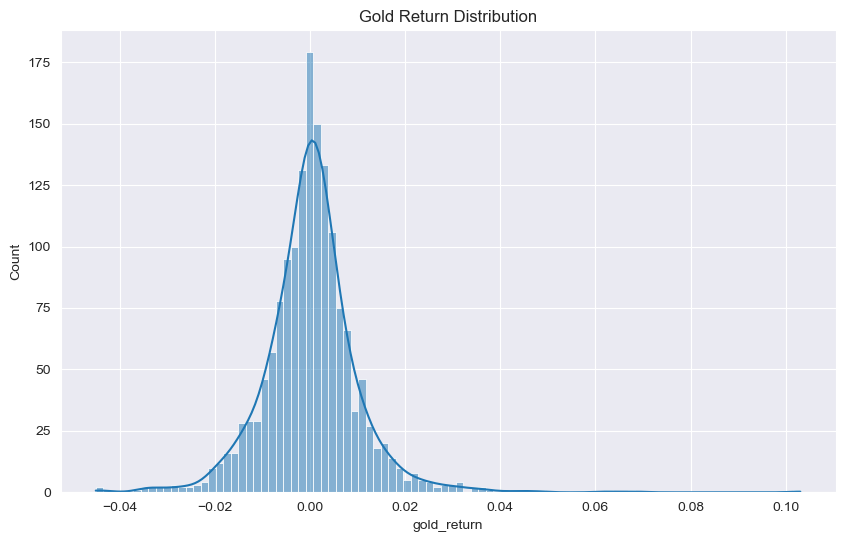

In [31]:
# plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True)
plt.title('Gold Return Distribution')
plt.show()

#### Remove Highly Correlated Features

In [39]:
X_vif = utils.calculate_vif(X, correlation_threshold=1)
X_vif

Removing high VIF and correlated variables:   0%|          | 0/11 [00:00<?, ?it/s]

Removed variable: SPY return with VIF: 36.86
Removed variable: DIA return with VIF: 5.63
Removed variables with high VIF:
SPY return: 36.86
DIA return: 5.63


,QQQ return,CPI,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return,Polarity,Subjectivity
0,0.013368,226.889,0.09,-0.005839,0.011077,-0.043535,-0.008508,-0.050000,0.437500
1,0.014291,226.889,0.08,-0.008590,0.011620,-0.062585,-0.001040,0.050000,0.512500
2,0.014812,226.889,0.09,0.031919,0.021989,-0.076012,-0.007679,-0.051852,0.179630
3,0.009155,226.889,0.09,-0.003856,0.002890,-0.030967,0.004460,0.050000,0.175000
4,0.000353,226.889,0.09,-0.028987,-0.025296,0.056488,0.010577,-0.009444,0.181319
...,...,...,...,...,...,...,...,...,...
1590,-0.004222,252.776,2.40,-0.009606,-0.000775,-0.025951,0.000000,0.055795,0.422235
1591,0.006929,254.202,2.40,-0.020298,0.004033,-0.081867,0.003848,0.015000,0.285000
1592,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308,0.166667,0.483333
1593,0.013495,256.571,2.39,-0.035841,0.004109,-0.067639,0.007386,0.000000,0.000000


#### Split Data

In [53]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_vif, y, test_size=0.2, random_state=42)

#### Feature Scaling

In [49]:
# scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[ 0.66219239,  0.74772698,  0.64720146, ..., -0.08662445,
        -1.94859515, -0.86599396],
       [-0.02694211,  0.04479458, -0.33995732, ..., -0.6268005 ,
        -0.32272956, -1.58518386],
       [-0.39095905, -0.88369737,  0.08607245, ..., -0.03961425,
        -0.32272956, -1.58518386],
       ...,
       [-0.76799485, -0.41472593, -0.66940219, ..., -0.2052175 ,
        -0.32272956, -1.58518386],
       [ 0.15209065,  0.51347968, -0.2715508 , ..., -0.83947978,
        -0.48079983, -0.23004363],
       [ 0.26565367,  0.49254856,  0.1890995 , ..., -0.51974544,
         0.23197752, -0.6615184 ]])

## Model Building

### Scoring and Cross-Validation

In [54]:
# Define a custom scorer
scorer = make_scorer(mean_absolute_error)

In [55]:
# Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

### Linear Regression

In [56]:
# add a constant to the features
X_ols = sm.add_constant(X_train)

# fit the model
ols = sm.OLS(y_train, X_ols).fit()

# print the summary
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:            gold_return   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.043
Date:                Mon, 18 Nov 2024   Prob (F-statistic):              0.403
Time:                        20:11:59   Log-Likelihood:                 4015.4
No. Observations:                1276   AIC:                            -8011.
Df Residuals:                    1266   BIC:                            -7959.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0203      0.020  